Imports

In [41]:
import pandas as pd
from ast import literal_eval
import numpy as np

TF-IDF class. Contains methods which can easily access relevant information from the csv file which the class reads, which represents the TF-IDF model.

TF-IDF stands for Term Frequency - Inverse Document Frequency. It gives each keyword-document combination a weight, based on how often it occurs in the document, but also based on how often it occurs in all documents. This ensures that words which occur often in many documents do not receive high weights, rather only words which are relatively unique to a document and occur frequently in that document get high weights.

If all documents are about topic A, we do not care that document x contains is about document A.

Implementation wise, the TF-IDF is a csv file with each row representing a document and each column representing a keyword, the value at i,j represents the weight that keyword j has in document i.

In [56]:
class TfIdf:
    def __init__(self):
        # Loading in the tf-idf
        # Rows are documents, the first column is the document id
        # Columns are keywords, the first row is the keyword id
        self.tfidf = pd.read_csv("../data/tf_idf/tf_idf_time_weighted.csv")

        # Loading in the keywords
        # Two columns, column 1 is id, column 2 is keyword
        # We can access the weight in the tf-idf by first accessing the id number from the keyword file
        self.tfidf_keywords = pd.read_csv("../data/tf_idf/tf_idf_keywords_new.csv")
        self.tfidf_keywords.columns = ["id", "keyword"]

    def get_id_by_keyword(self, keyword):
        return self.tfidf_keywords.id.iloc[self.tfidf_keywords[self.tfidf_keywords.keyword == keyword].index].values[0]


    def get_keyword_by_id(self, id):
        return self.tfidf_keywords.loc[self.tfidf_keywords.id==id, 'keyword'].iloc[0]
    # Method to get the tfidf value of a keyword in a page
    def get_tf_idf_value(self, page_id, keyword):
        keyword_id = self.get_id_by_keyword(keyword)
        return self.tfidf.iloc[page_id-1, keyword_id + 1]

    def get_all_keywords_by_id(self, page_id):
        keywords = self.tfidf.iloc[page_id-1][1:].values
        return keywords

    def get_all_keywords_by_id_normalized(self, page_id):
        keywords_weights = self.get_all_keywords_by_id(page_id)
        sum_value = sum(keywords_weights)
        if sum_value == 0:
            return keywords_weights
        keywords_weights_normalized = keywords_weights/sum_value
        return keywords_weights_normalized

    def get_number_of_keywords(self):
        return self.tfidf_keywords.shape[0]

Instantiate the object

In [57]:
tfidf = TfIdf()

Read in the dataset of visits, used to test the information need prediction.

In [46]:
generic = lambda x: literal_eval(x)

conv = {'url_id_path': generic,
        'seconds_spent_path': generic}
df = pd.read_csv('../data/clickdata/dataNoUnscrapedVisitsOrUnder20Sec.csv', converters=conv)

Create seperate dataframes for the paths taken and for the seconds spent on each url.
In paths, index 0 gives a list of urls, the equivalent index 0 in seconds represents how many seconds the user spent on the equal index urls.

In [47]:
paths = df.url_id_path
seconds = df.seconds_spent_path

In [48]:
paths.head(10)

0    [188, 1557, 3, 1, 13, 14, 21, 16, 14, 18, 14, ...
1                               [1557, 3, 1, 13, 1556]
2                                      [188, 194, 784]
3                                    [23, 1557, 3, 13]
4        [1557, 3, 1, 13, 1, 1559, 12, 1559, 17, 1556]
5                                      [186, 217, 186]
6                                                [188]
7                                [1557, 3, 13, 23, 13]
8                             [23, 1557, 23, 1557, 13]
9                                [1557, 1, 1556, 1557]
Name: url_id_path, dtype: object

In [49]:
seconds.head(10)

0    [4, 17, 5, 7, 31, 27, 126, 55, 9, 13, 3, 328, 5]
1                                   [14, 4, 4, 33, 0]
2                                          [5, 20, 0]
3                                    [0, 163, 4, 151]
4            [12, 14, 34, 66, 358, 9, 18, 19, 908, 0]
5                                        [14, 868, 0]
6                                                [40]
7                                  [71, 7, 751, 1, 9]
8                                  [1, 298, 1, 35, 6]
9                                    [27, 15, 12, 74]
Name: seconds_spent_path, dtype: object

Simplified implementation of IUNIS, which simply looks at the keywords which the user comes across, does not use the adjacency matrix, proximal cues, and spreading activation.
It seems that these are mostly important for WUFIS, which we are not interested in, thus implementing it is not worth the effort.

Input is the ordered list of page id's that the user has visited.
For each page, take the TF-IDF values from that page, which is a row of keywords, with either 0 if the keyword is not present or [0,1] if it is.

Then, for each next page, we add the TF-IDF values onto the existing weights.

Eventually we can sort the list and we will have the keywords with the highest weight on top, which then represents the most relevant keywords in the visit up until now, and acts as our prediction for what the user is looking for.
Instead of only looking at the user alone, we can also compare their information need to information needs of other users, and by looking at where the other users end up, we can predict where our user might want to end up.

Optionally, a decay factor can be introdced. Essentially, every iteration, all values are divided by a factor, meaning that keywords on recent pages are more biased and weighted more heavily.

It is also possible to give more weight to pages based on how much time the user spent on that page.

In [60]:
from pandas import DataFrame
#Method which essentially just takes the keywords and their weights on each page the user visits, continues to the next url, and then sums the weights.
#Be sure to realise that only passing a path will execute the normal implementation, which simply sums all new tf-idf values of each url.
#This is because the default decay_factor value is 1, meaning that nothing changes, and the default secs is None, if that is None, the if statement with secs is never entered and we do not take time into account.
#Sorted gives an option to sort the vector before returning, this puts the most relevant keywords on top, but does not allow for easy similarity comparison, thus should only be used if this is not the intention
def find_keyword_weights(path, decay_factor=1, secs=None, sorted=False):
    #initiate array of weights (weights start as 0, size=num of keywords)
    weights = np.zeros(tfidf.get_number_of_keywords())
    #ensures all output is visible
    pd.options.display.max_rows = 0
    #Iterate over each page url
    for i in range(len(path)):
        #Divide the weights by the decay factor (1 by default, no decay in that case)
        weights = weights/decay_factor
        #Initialize the tf-idf weights of the current page
        new_weights = tfidf.get_all_keywords_by_id_normalized(path[i])
        #If we are taking time into account, multiply the weights by the amount of time spent on this page
        if secs is not None:
            new_weights*=secs[i]
        #Add the new weights to the existing weights
        weights += new_weights
        #Normalize such that the largest value becomes 1
        if max(weights)==0:
            return weights
        weights /= max(weights)
    #Option to sort s.t. max weights are on top.
    if sorted:
        df = DataFrame(weights, columns=['weights'])
        return df.sort_values(by=['weights'], ascending=False)
    return weights

This is a method to print out the top 'num_of_words' weighted keywords.

In [51]:
def print_top_weights_as_words(num_of_words, weights):
    top_weights = weights.head(num_of_words)
    i=0
    for index in top_weights.index:
        print(str(tfidf.get_keyword_by_id(index)) + " : " + str(top_weights.weights.iloc[i]))
        i+=1
    print("\n")

Line 2 in this section gets rid of all useless pages (login, logout, search, and error)
Then, if the user has visited more than 5 pages, it will compute the keywords up until page 5.

In [52]:
def remove_keywordless_pages(path, seconds):
    indices_to_remove = []
    for i in range(len(path)):
        if path[i]>1555:
            indices_to_remove.append(i)
    for i in range(len(indices_to_remove)-1, -1, -1):
        index = indices_to_remove[i]
        path.pop(index)
        seconds.pop(index)
    return path, seconds

These sections computes the weights after each different page to see how it changes throughout the visit
We can do interesting experiments to see how information need changes throughout the visit, and to find out at which page index we can best make our prediction final

In [53]:
print(paths[0])
print(seconds[0])
path, secs = remove_keywordless_pages(paths[0], seconds[0])
print(path)
print(secs)


[188, 1557, 3, 1, 13, 14, 21, 16, 14, 18, 14, 5, 1556]
[4, 17, 5, 7, 31, 27, 126, 55, 9, 13, 3, 328, 5]
[188, 3, 1, 13, 14, 21, 16, 14, 18, 14, 5]
[4, 5, 7, 31, 27, 126, 55, 9, 13, 3, 328]


In [62]:
for i in range(len(path)):
    subpath = path[:i+1]
    weights = find_keyword_weights(subpath, decay_factor=7, sorted=True)
    print_top_weights_as_words(10, weights)

verder : 1.0
of : 0.9384426699894147
der : 0.9325188923991685
samenvallende : 0.9288504212919083
en : 0.9251386039946596
de : 0.9036176981072715
lees : 0.8889338431662774
uw : 0.8711314163880793
diensttijd : 0.8580229689506655
nieuws : 0.8403499256641727


verder : 1.0
of : 0.9384426699894148
der : 0.9325188923991685
samenvallende : 0.9288504212919084
en : 0.9251386039946597
de : 0.9036176981072717
lees : 0.8889338431662775
uw : 0.8711314163880793
diensttijd : 0.8580229689506657
nieuws : 0.8403499256641727


verder : 1.0
of : 0.9384426699894148
der : 0.9325188923991685
samenvallende : 0.9288504212919084
en : 0.9251386039946597
de : 0.9036176981072717
lees : 0.8889338431662775
uw : 0.8711314163880793
diensttijd : 0.8580229689506658
nieuws : 0.8403499256641727


berichten : 1.0
verder : 0.14285714285714285
of : 0.1340632385699164
der : 0.13321698462845263
samenvallende : 0.13269291732741548
en : 0.1321626577135228
de : 0.12908824258675308
lees : 0.12699054902375392
uw : 0.124447345198297

In [63]:
for i in range(len(path)):
    subpath = path[:i+1]
    subsecs = secs[:i+1]
    weights = find_keyword_weights(subpath, secs=subsecs, decay_factor=1.25)


Idea for evaluation:

Look at the keywords at a specific time (we must make sure the weights are normalised, they are not in the implementation above), and compare it with a certain page near the end of the user visit to see if the user found their need.
We can do either the last page, or maybe the page that the user has spent the most time on.
The problem becomes that we want to evaluate the prediction of the information need, and there will be inaccuracies as the user data is not necessarily correct.
But if we can create a metric and we can compare different implementations with the same metric we still have something nice.


In [64]:
import math


def estimate_most_important_page(path, seconds):
    path = path[int(len(path)/2):]
    seconds = seconds[int(len(seconds)/2):]
    index = seconds.index(max(seconds))
    return path[index]

def find_keywords_of_estimated_most_important_page(path, seconds):
    id = estimate_most_important_page(path, seconds)
    return tfidf.get_all_keywords_by_id_normalized(id)

from numpy import dot
from numpy.linalg import norm
def similarity_estimated_information_need(information_need, keywords_most_important_page):
    def cosine_similarity(list_1, list_2):
        cos_sim = dot(list_1, list_2) / (norm(list_1) * norm(list_2))
        return cos_sim
    similarity = cosine_similarity(information_need, keywords_most_important_page)
    if math.isnan(similarity):
        return 0
    return similarity

In [65]:
def compute_similarities(subpath_size):
    count=0
    similarity_list = []
    for j in range(len(paths)):
        path, second = remove_keywordless_pages(paths[j], seconds[j])
        if count == 5000:
            break
        if len(path)>5:
            count+=1
            subpath = path[:subpath_size]
            weights = find_keyword_weights(subpath)
            similarity_list.append(similarity_estimated_information_need(weights,find_keywords_of_estimated_most_important_page(path, second)))
    return similarity_list

In [66]:
similarity_scores_basic = []
for i in range(1,8):
    similarity_scores_basic.append(np.mean(compute_similarities(i)))

C:\Users\01din\AppData\Local\Temp\ipykernel_18800\2398819497.py:18: RuntimeWarning: invalid value encountered in double_scalars
  cos_sim = dot(list_1, list_2) / (norm(list_1) * norm(list_2))


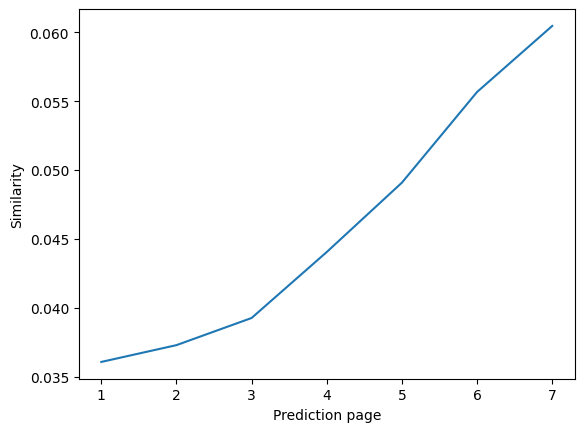

In [67]:
from matplotlib import pyplot as plt
plt.plot(list(range(1,8)), similarity_scores_basic)
plt.xlabel("Prediction page")
plt.ylabel("Similarity")
plt.show()

In [68]:
def compute_similarities_decay(decay_factor):
    count=0
    similarity_list = []
    for j in range(len(paths)):
        path, second = remove_keywordless_pages(paths[j], seconds[j])
        if count == 5000:
            break
        if len(path)>5:
            count+=1
            subpath = path[:3]
            weights = find_keyword_weights(subpath, decay_factor=decay_factor)
            similarity_list.append(similarity_estimated_information_need(weights, find_keywords_of_estimated_most_important_page(path, second)))
    return similarity_list

In [69]:
similarity_scores_decay = []

for i in range(1,50):
    similarity_scores_decay.append(np.mean(compute_similarities_decay(i)))

C:\Users\01din\AppData\Local\Temp\ipykernel_18800\2398819497.py:18: RuntimeWarning: invalid value encountered in double_scalars
  cos_sim = dot(list_1, list_2) / (norm(list_1) * norm(list_2))


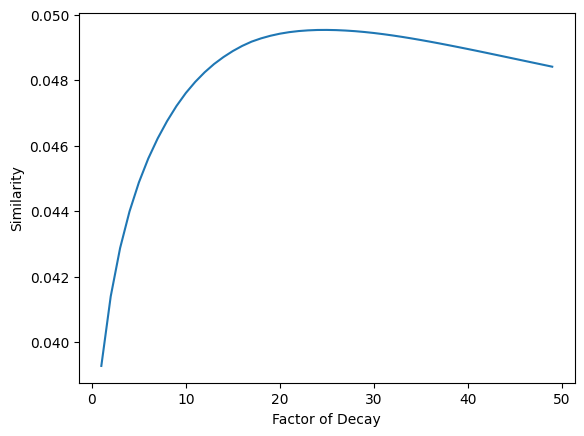

In [70]:
plt.plot(list(range(1,50)), similarity_scores_decay)
plt.xlabel("Factor of Decay")
plt.ylabel("Similarity")
plt.show()

In [71]:
def compute_similarities_time(subpath_size, decay=1):
    count=0
    similarity_list = []
    for j in range(len(paths)):
        path, second = remove_keywordless_pages(paths[j], seconds[j])
        if count == 5000:
            break
        if len(path)>5:
            count+=1
            subpath = path[:subpath_size]
            subsecs = second[:subpath_size]
            weights = find_keyword_weights(subpath, secs=subsecs, decay_factor=decay)
            similarity_list.append(similarity_estimated_information_need(weights, find_keywords_of_estimated_most_important_page(path, second)))
    return similarity_list

In [72]:
similarity_scores_time = []
for i in range(1,8):
    similarity_scores_time.append(np.mean(compute_similarities_time(i)))

C:\Users\01din\AppData\Local\Temp\ipykernel_18800\2398819497.py:18: RuntimeWarning: invalid value encountered in double_scalars
  cos_sim = dot(list_1, list_2) / (norm(list_1) * norm(list_2))


[0.03600017255248774, 0.04236991134125027, 0.04777733725304169, 0.0782537270261392, 0.10646395493759826, 0.13343495140401934, 0.1476822414678785]


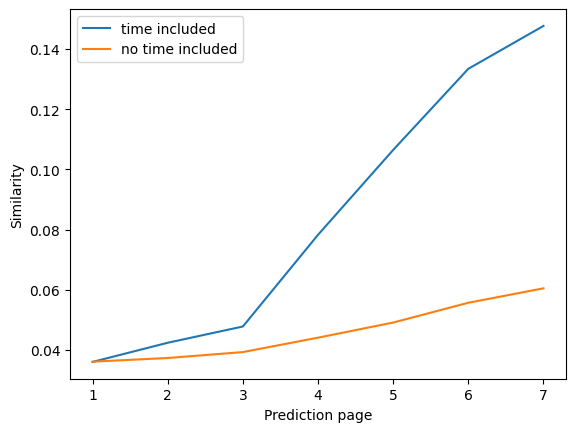

In [73]:
print(similarity_scores_time)
plt.plot(list(range(1,8)), similarity_scores_time, label="time included")
plt.plot(list(range(1,8)), similarity_scores_basic, label='no time included')
plt.legend()
plt.xlabel("Prediction page")
plt.ylabel("Similarity")
plt.show()

In [ ]:
similarity_scores_time_decay = []
for i in range(1,50):
    similarity_scores_time_decay.append(np.mean(compute_similarities_time(3, i)))

C:\Users\01din\AppData\Local\Temp\ipykernel_18800\2398819497.py:18: RuntimeWarning: invalid value encountered in double_scalars
  cos_sim = dot(list_1, list_2) / (norm(list_1) * norm(list_2))


In [ ]:
plt.plot(list(range(1,50)), similarity_scores_time_decay, label="time included")
plt.plot(list(range(1,50)), similarity_scores_decay, label='no time included')
plt.legend()
plt.xlabel("Factor of Decay")
plt.ylabel("Similarity")
plt.show()

In [ ]:
values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
similarity_scores_time_decay_below_one = []
for i in values:
    similarity_scores_time_decay_below_one.append(np.mean(compute_similarities_time(3, i)))

In [ ]:
plt.plot(values, similarity_scores_time_decay_below_one, label="time included")
plt.legend()
plt.xlabel("Factor of Decay")
plt.ylabel("Similarity")
plt.show()